# Training and Basic Evaluation for a 3D Binary Classifier

If using MedMNIST for the first time, you will need to install medmnist.

In [1]:
#!pip install medmnist

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

import medmnist
from medmnist import INFO

import sys
sys.path.insert(0,"../")

import dataset_without_pytorch

from functions import split_data, get_label_counts, build_basic_model, argmax_array, generate_training_mixup_images
from plotting_functions import plot_history

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


We set some of our parameters here. The data flag is 'pneumoniamnist' - a binary pneumonia dataset. 

In [4]:
data_flag = 'fracturemnist3d'

download = True

image_size = 28

info = INFO[data_flag]

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [5]:
# load the data
train_dataset = DataClass(split='train', download=download, size = image_size)
test_dataset = DataClass(split='test', download=download, size = image_size)
val_dataset = DataClass(split='val', download=download, size = image_size)

Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\fracturemnist3d.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\fracturemnist3d.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\fracturemnist3d.npz


In [6]:
print(train_dataset)
print(test_dataset)

Dataset FractureMNIST3D (fracturemnist3d)
    Number of datapoints: 1027
    Root location: C:\Users\Will Poulett\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'buckle rib fracture', '1': 'nondisplaced rib fracture', '2': 'displaced rib fracture'}
    Number of samples: {'train': 1027, 'val': 103, 'test': 240}
    Description: The FractureMNIST3D is based on the RibFrac Dataset, containing around 5,000 rib fractures from 660 computed tomography 153 (CT) scans. The dataset organizes detected rib fractures into 4 clinical categories (i.e., buckle, nondisplaced, displaced, and segmental rib fractures). As we use low-resolution images, we disregard segmental rib fractures and classify 3 types of rib fractures (i.e., buckle, nondisplaced, and displaced). For each annotated fracture area, we calculate its center and resize the center-cropped 64mm×64mm×64mm image into 28×28×28. The official split of training, validation and test set is

Here we split our data into train, validation, and 2 testing datasets. One is for MUBA, one is for further evaluation. 

In [7]:
RANDOM_SEED = 1

X_train, y_train, X_val, y_val, X_test_A, y_test_A, X_test_B, y_test_B = split_data(
  train_dataset, test_dataset, val_dataset, RANDOM_SEED = RANDOM_SEED, one_hot_encoded = True, num_classes=3, image_size = image_size, three_d=True)

In [8]:
get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = ['buckle rib fracture','nondisplaced rib fracture', 'displaced rib fracture'])


Train
{(0, 0, 1): 171, (0, 1, 0): 383, (1, 0, 0): 473}  ['buckle rib fracture', 'nondisplaced rib fracture', 'displaced rib fracture']

Val
{(0, 0, 1): 21, (0, 1, 0): 40, (1, 0, 0): 42}  ['buckle rib fracture', 'nondisplaced rib fracture', 'displaced rib fracture']

Test A
{(0, 0, 1): 16, (0, 1, 0): 34, (1, 0, 0): 22}  ['buckle rib fracture', 'nondisplaced rib fracture', 'displaced rib fracture']

Test B
{(0, 0, 1): 30, (0, 1, 0): 70, (1, 0, 0): 68}  ['buckle rib fracture', 'nondisplaced rib fracture', 'displaced rib fracture']


## Basic Model 

This first model we call 'basic' as we are not augmenting the data in any way during training. 

In [9]:
model = build_basic_model(input_shape = (image_size,image_size, image_size), num_classes = 3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        8096      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        2

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./simple_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"simple_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [11]:
history = model.fit(X_train,y_train, batch_size = 32, epochs = 30 , validation_data = (X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

Epoch 1/30
33/33 [==============================] - 3s 44ms/step - loss: 1.5948 - accuracy: 0.4362 - val_loss: 1.1512 - val_accuracy: 0.2039 - lr: 0.0010
Epoch 2/30
 3/33 [=>............................] - ETA: 1s - loss: 1.1470 - accuracy: 0.4583

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 1s 35ms/step - loss: 1.1352 - accuracy: 0.4606 - val_loss: 1.2918 - val_accuracy: 0.2039 - lr: 0.0010
Epoch 3/30
31/33 [===========================>..] - ETA: 0s - loss: 1.0362 - accuracy: 0.4929
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
33/33 [==============================] - 1s 37ms/step - loss: 1.0345 - accuracy: 0.4898 - val_loss: 1.4794 - val_accuracy: 0.2039 - lr: 0.0010
Epoch 4/30
33/33 [==============================] - 1s 39ms/step - loss: 0.9040 - accuracy: 0.5463 - val_loss: 1.5674 - val_accuracy: 0.2039 - lr: 3.0000e-04
Epoch 5/30
31/33 [===========================>..] - ETA: 0s - loss: 0.8296 - accuracy: 0.5998
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
33/33 [==============================] - 1s 37ms/step - loss: 0.8253 - accuracy: 0.6047 - val_loss: 1.9137 - val_accuracy: 0.2039 - lr: 3.0000e-04
Epoch 6/30
33/33 [==============================] - 1s 40ms/step - lo

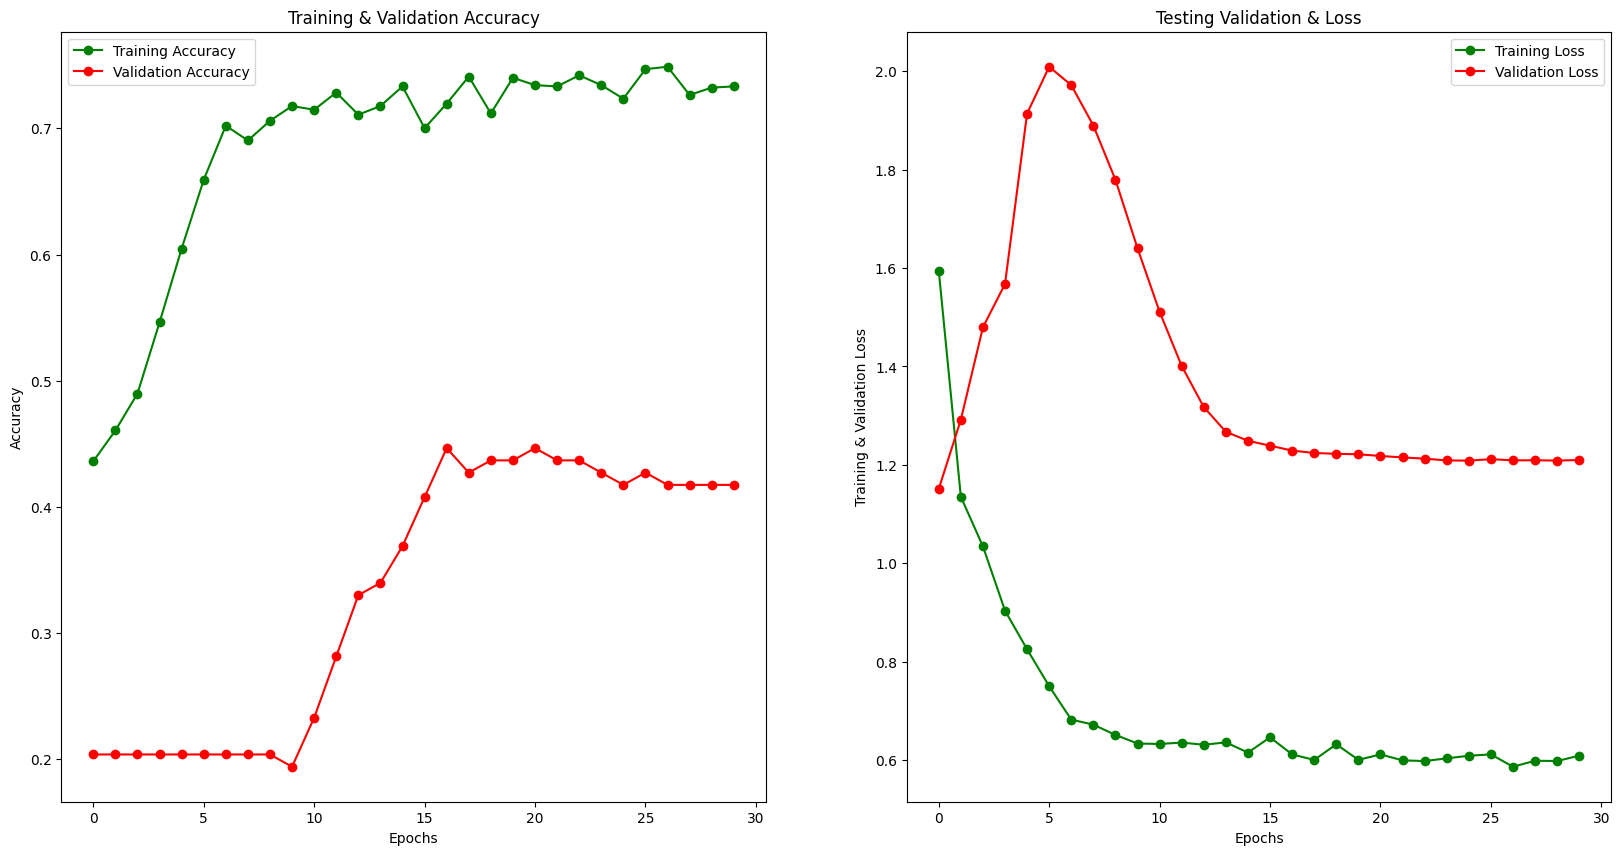

In [12]:
plot_history(history, size=(20,10), epochs = 30)

In [13]:
print(history.history["accuracy"])
print(history.history["loss"])
print(history.history["val_accuracy"])
print(history.history["val_loss"])

[0.43622201681137085, 0.4605647623538971, 0.48977604508399963, 0.5462512373924255, 0.6046738028526306, 0.6592015624046326, 0.7020447850227356, 0.6903602480888367, 0.7059396505355835, 0.7176241278648376, 0.7147030234336853, 0.7283349633216858, 0.7108081579208374, 0.7176241278648376, 0.7332035303115845, 0.700097382068634, 0.719571590423584, 0.7409932017326355, 0.7117818593978882, 0.7400195002555847, 0.7341772317886353, 0.7332035303115845, 0.7419669032096863, 0.7341772317886353, 0.7234663963317871, 0.746835470199585, 0.7487828731536865, 0.7263875603675842, 0.7322297692298889, 0.7332035303115845]
[1.5948381423950195, 1.1352269649505615, 1.0344737768173218, 0.9039574265480042, 0.825286865234375, 0.7504246830940247, 0.6824833154678345, 0.672418475151062, 0.6514378190040588, 0.6340441703796387, 0.6331518888473511, 0.6359171271324158, 0.6315204501152039, 0.6363567113876343, 0.6156125068664551, 0.6465226411819458, 0.6118937730789185, 0.6006717681884766, 0.6324384212493896, 0.600845456123352, 0.

In [14]:
best_model = keras.models.load_model("./simple_models/best_model_epoch_01.h5")

In [15]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['buckle rib fracture','nondisplaced rib fracture', 'displaced rib fracture']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['buckle rib fracture','nondisplaced rib fracture', 'displaced rib fracture']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

6/6 [==============================] - 0s 9ms/step
Test Set A
                           precision    recall  f1-score   support

      buckle rib fracture       0.00      0.00      0.00        22
nondisplaced rib fracture       0.00      0.00      0.00        34
   displaced rib fracture       0.22      1.00      0.36        16

                 accuracy                           0.22        72
                macro avg       0.07      0.33      0.12        72
             weighted avg       0.05      0.22      0.08        72


Test Set B
                           precision    recall  f1-score   support

      buckle rib fracture       0.00      0.00      0.00        68
nondisplaced rib fracture       0.00      0.00      0.00        70
   displaced rib fracture       0.18      1.00      0.30        30

                 accuracy                           0.18       168
                macro avg       0.06      0.33      0.10       168
             weighted avg       0.03      0.18    

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [19]:
X_train_mixup, y_train_mixup = generate_training_mixup_images(X_train, y_train, 15)

In [20]:
X_train_mixup = np.array(X_train_mixup).reshape(-1, image_size, image_size, image_size)
y_train_mixup = np.array(y_train_mixup)

In [21]:
len(X_train_mixup),len(y_train_mixup)

(15405, 15405)

## Oversampling

In [27]:
get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = ['vessel', 'aneurysm'])


Train
{(0, 0, 1): 171, (0, 1, 0): 383, (1, 0, 0): 473}  ['vessel', 'aneurysm']

Val
{(0, 0, 1): 21, (0, 1, 0): 40, (1, 0, 0): 42}  ['vessel', 'aneurysm']

Test A
{(0, 0, 1): 16, (0, 1, 0): 34, (1, 0, 0): 22}  ['vessel', 'aneurysm']

Test B
{(0, 0, 1): 30, (0, 1, 0): 70, (1, 0, 0): 68}  ['vessel', 'aneurysm']


In [28]:
X_train_oversample = []
y_train_oversample = []

for X, y in zip(X_train,y_train):
    if y[2] == 1: 
        for i in range(2):
            X_train_oversample.append(X)
            y_train_oversample.append(y)
    else:
        X_train_oversample.append(X)
        y_train_oversample.append(y)

X_train_oversample = np.array(X_train_oversample).reshape(-1, image_size, image_size, image_size)
y_train_oversample = np.array(y_train_oversample)

In [29]:
get_label_counts(y_train_oversample,y_val,y_test_A,y_test_B,class_names = ['buckle rib fracture','nondisplaced rib fracture', 'displaced rib fracture'])


Train
{(0, 0, 1): 342, (0, 1, 0): 383, (1, 0, 0): 473}  ['buckle rib fracture', 'nondisplaced rib fracture', 'displaced rib fracture']

Val
{(0, 0, 1): 21, (0, 1, 0): 40, (1, 0, 0): 42}  ['buckle rib fracture', 'nondisplaced rib fracture', 'displaced rib fracture']

Test A
{(0, 0, 1): 16, (0, 1, 0): 34, (1, 0, 0): 22}  ['buckle rib fracture', 'nondisplaced rib fracture', 'displaced rib fracture']

Test B
{(0, 0, 1): 30, (0, 1, 0): 70, (1, 0, 0): 68}  ['buckle rib fracture', 'nondisplaced rib fracture', 'displaced rib fracture']


In [30]:
model = build_basic_model(input_shape = (image_size,image_size,image_size), num_classes = 3, loss="categorical_crossentropy",final_activation="softmax")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        8096      
                                                                 
 batch_normalization_15 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_16 (Ba  (None, 14, 14, 64)       

In [31]:
X_train_mixup, y_train_mixup = generate_training_mixup_images(X_train_oversample, y_train_oversample, 15)

In [32]:
X_train_mixup = np.array(X_train_mixup).reshape(-1, image_size, image_size, image_size)
y_train_mixup = np.array(y_train_mixup)

In [33]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./oversample_mixup_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./oversample_mixup_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [34]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(X_train_mixup)

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:2092: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (17970, 28, 28, 28) (28 channels).
  warnings.warn(


In [35]:
X_val_oversample = []
y_val_oversample = []

for X, y in zip(X_val,y_val):
    if y[1] == 2: 
        for i in range(2):
            X_val_oversample.append(X)
            y_val_oversample.append(y)
    else:
        X_val_oversample.append(X)
        y_val_oversample.append(y)

X_val_oversample = np.array(X_val_oversample).reshape(-1, image_size, image_size, image_size)
y_val_oversample = np.array(y_val_oversample)

In [36]:
X_val_mixup, y_val_mixup = generate_training_mixup_images(X_val_oversample, y_val_oversample, 10)

In [37]:
X_val_mixup = np.array(X_train_mixup).reshape(-1, image_size, image_size, image_size)
y_val_mixup = np.array(y_train_mixup)

In [38]:
history_3 = model.fit(datagen.flow(X_train_mixup,y_train_mixup, batch_size = 32), epochs = 60 ,  validation_data = datagen.flow(X_val_mixup, y_val_mixup) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (17970, 28, 28, 28) (28 channels).
  warnings.warn(


Epoch 1/60
562/562 [==============================] - 63s 110ms/step - loss: 1.0709 - accuracy: 0.4550 - val_loss: 1.0026 - val_accuracy: 0.4997 - lr: 0.0010
Epoch 2/60
562/562 [==============================] - 66s 117ms/step - loss: 0.9813 - accuracy: 0.5273 - val_loss: 0.9612 - val_accuracy: 0.5381 - lr: 0.0010
Epoch 3/60
562/562 [==============================] - 69s 122ms/step - loss: 0.9437 - accuracy: 0.5610 - val_loss: 0.9476 - val_accuracy: 0.5713 - lr: 0.0010
Epoch 4/60
562/562 [==============================] - 69s 123ms/step - loss: 0.9087 - accuracy: 0.5834 - val_loss: 0.8849 - val_accuracy: 0.6144 - lr: 0.0010
Epoch 5/60
562/562 [==============================] - 68s 122ms/step - loss: 0.8753 - accuracy: 0.6121 - val_loss: 0.8615 - val_accuracy: 0.6215 - lr: 0.0010
Epoch 6/60
562/562 [==============================] - 66s 118ms/step - loss: 0.8442 - accuracy: 0.6306 - val_loss: 0.8463 - val_accuracy: 0.6330 - lr: 0.0010
Epoch 7/60
562/562 [==============================] 

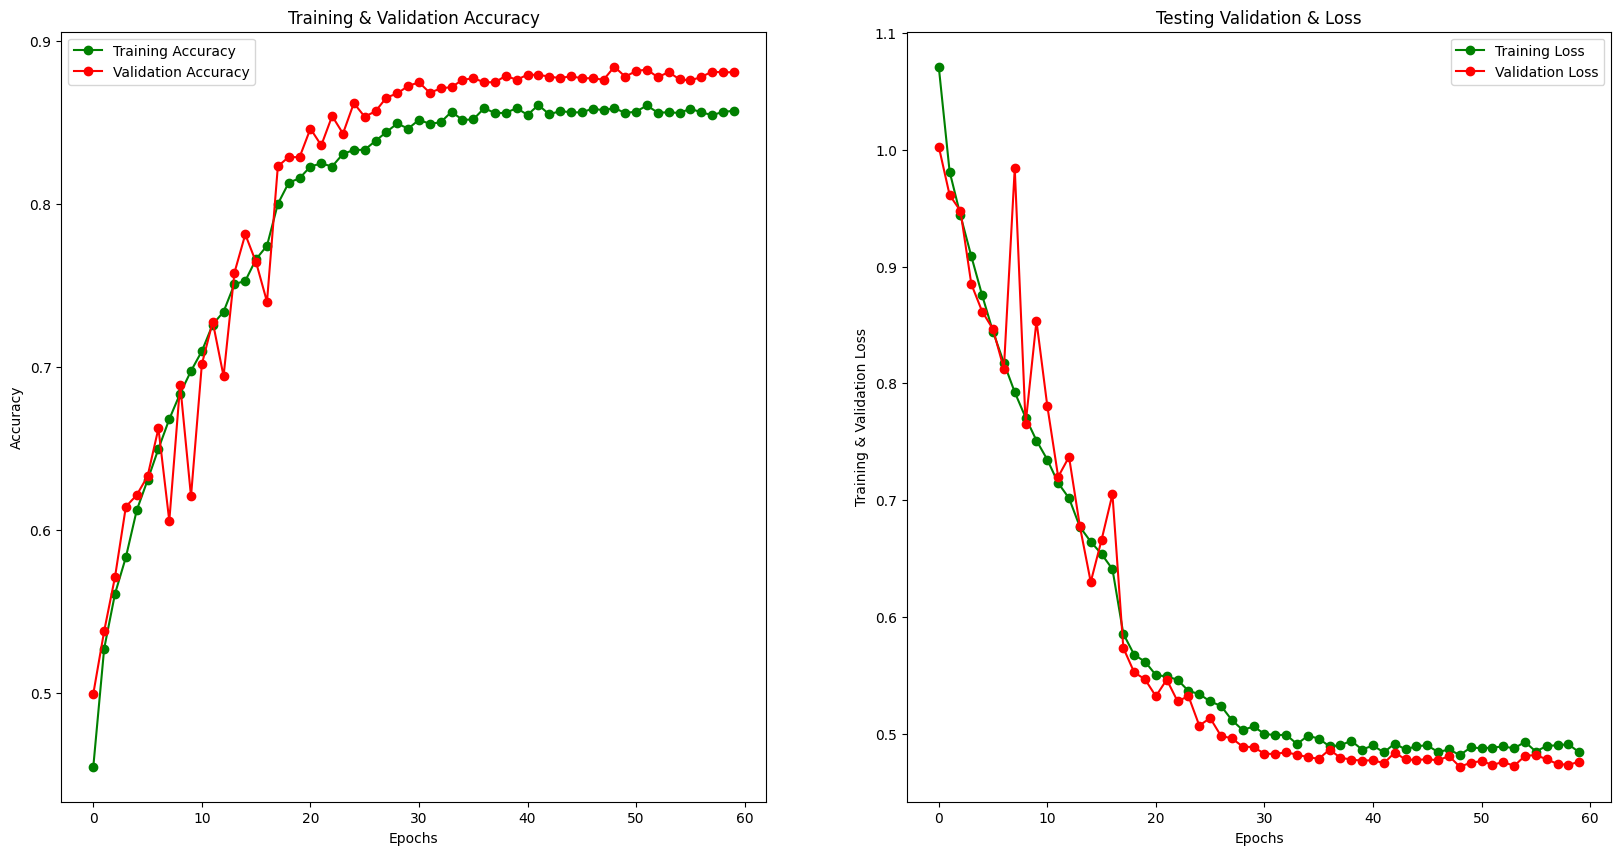

In [40]:
plot_history(history_3, size=(20,10), epochs = 60)

In [41]:
best_model = keras.models.load_model("./oversample_mixup_models/best_model_epoch_49.h5")

In [43]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['buckle rib fracture','nondisplaced rib fracture', 'displaced rib fracture']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['buckle rib fracture','nondisplaced rib fracture', 'displaced rib fracture']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

6/6 [==============================] - 0s 11ms/step
Test Set A
                           precision    recall  f1-score   support

      buckle rib fracture       0.38      0.50      0.43        22
nondisplaced rib fracture       0.58      0.41      0.48        34
   displaced rib fracture       0.37      0.44      0.40        16

                 accuracy                           0.44        72
                macro avg       0.44      0.45      0.44        72
             weighted avg       0.47      0.44      0.45        72


Test Set B
                           precision    recall  f1-score   support

      buckle rib fracture       0.50      0.66      0.57        68
nondisplaced rib fracture       0.61      0.36      0.45        70
   displaced rib fracture       0.49      0.60      0.54        30

                 accuracy                           0.52       168
                macro avg       0.53      0.54      0.52       168
             weighted avg       0.54      0.52   

In [ ]:
X_train_mixup, y_train_mixup = generate_training_mixup_images(X_train_oversample, y_train_oversample, 3)

In [ ]:
X_train_mixup = np.array(X_train_mixup).reshape(-1, image_size, image_size, image_size)
y_train_mixup = np.array(y_train_mixup)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./oversample_mixup_models_2/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./oversample_mixup_models_2/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [ ]:
model = keras.models.load_model("./oversample_mixup_models/best_model_epoch_12.h5")

In [ ]:
history_6 = model.fit(datagen.flow(X_train_mixup,y_train_mixup, batch_size = 32), epochs = 30 ,  validation_data = datagen.flow(X_val_mixup, y_val_mixup) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

In [ ]:
best_model = keras.models.load_model("./oversample_mixup_models_2/best_model_epoch_06.h5")

In [ ]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['vessel', 'aneurysm']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['vessel', 'aneurysm']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))